# Sepsis Predictor using XGBoost

## Overview
<p>
This page details the process of using a gradient boosted decision tree algorithm (XGBoost) for automated detection of Sepsis. The data used in this evaluation was provided as part of the <a href="https://physionet.org/content/challenge-2019/1.0.0/">Pysionet Computing in Cardiology Challenge 2019 </a>. 
</p>

## Data Exploration

The data is a combination of Vitals statistics and Laboratory values. 
**Vitals:**
<ul>
    <li> HR </li>
    <li> O2 Saturation </li>
    <li> Systolic Blood Pressure </li>
    <li> Mean Arterial Pressure </li>
    <li> Diastolic Blood Pressure </li>
    <li> Respiratory Rate </li>
    <li> EtCo2 </li>
    <li> Temperature (Celsius) </li>
</ul>

### Data Loading

<p>
This evaluation will focus on the first 3000 patients available in the dataset. 
</p>
<p>
Basic information for the dataset:
</p>


In [3]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from numpy import genfromtxt
import os
import qgrid
from matplotlib import pyplot
import pandas as pd

In [4]:
#Data Retreival

#Grab the data, 1000 files at a time:
count = 0 
max_files = 3000
directory = 'C:/Users/ns022927/Downloads/training_setA/training/'
#my_data = genfromtxt('C:/Users/ns022927/Downloads/training_setA/training/p000001.psv', delimiter='|', names=True)

for filename in os.listdir(directory):
    new_data = genfromtxt(os.path.join(directory, filename), dtype=float, skip_header=1, delimiter='|')
    if (count == 0 ):
        train_data = new_data
    else:
        train_data = np.concatenate((train_data, new_data))
    count+=1
    if (count > max_files):
        break

data_frame = pd.DataFrame(train_data, columns = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets','Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS','SepsisLabel'])
data_frame.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
count,107277.000000,102388.000000,40024.000000,98802.000000,104457.000000,60770.000000,104690.000000,0.0,12721.000000,9452.00000,...,8855.000000,978.000000,7639.000000,116696.000000,116696.000000,62331.000000,62331.000000,116696.000000,116696.000000,116696.000000
mean,85.240127,97.244335,37.041493,120.460178,78.507698,59.872885,18.749436,NaN,-0.657869,24.11897,...,12.020370,275.300613,199.628027,62.923912,0.575967,0.499992,0.500008,-48.262654,27.500960,0.022160
std,16.914461,2.933462,0.786801,21.317277,15.057709,12.565243,5.368394,NaN,4.375847,4.50512,...,6.819044,147.902911,109.097079,16.294041,0.494197,0.500004,0.500004,133.411848,28.587294,0.147205
min,22.000000,22.000000,20.900000,24.000000,20.000000,21.000000,1.000000,NaN,-32.000000,5.00000,...,0.100000,58.000000,5.000000,18.110000,0.000000,0.000000,0.000000,-3269.100000,1.000000,0.000000
25%,73.000000,96.000000,36.560000,105.000000,68.000000,51.000000,15.000000,NaN,-3.000000,22.00000,...,8.100000,172.000000,126.000000,52.300000,0.000000,0.000000,0.000000,-33.820000,11.000000,0.000000
50%,84.000000,98.000000,37.060000,118.000000,77.000000,58.000000,18.000000,NaN,0.000000,24.00000,...,10.900000,236.500000,182.000000,65.510000,1.000000,0.000000,1.000000,-2.370000,21.000000,0.000000
75%,96.000000,99.500000,37.560000,134.000000,87.000000,67.000000,22.000000,NaN,1.000000,27.00000,...,14.400000,345.000000,245.000000,75.680000,1.000000,1.000000,1.000000,-0.020000,35.000000,0.000000
max,200.000000,100.000000,41.220000,234.500000,295.000000,287.000000,67.000000,NaN,24.000000,52.00000,...,128.700000,954.000000,1111.000000,88.980000,1.000000,1.000000,1.000000,16.020000,283.000000,1.000000


### Missing Data
**Percentages of Missing Values per data type:**

In [5]:
data_frame.isnull().sum() / data_frame.shape[0]

HR                  0.080714
O2Sat               0.122609
Temp                0.657023
SBP                 0.153339
MAP                 0.104879
DBP                 0.479245
Resp                0.102883
EtCO2               1.000000
BaseExcess          0.890990
HCO3                0.919003
FiO2                0.857913
pH                  0.880142
PaCO2               0.908737
SaO2                0.946545
AST                 0.985355
BUN                 0.918112
Alkalinephos        0.985655
Calcium             0.951712
Chloride            0.916484
Creatinine          0.934359
Bilirubin_direct    0.998303
Glucose             0.873723
Lactate             0.963872
Magnesium           0.921668
Phosphate           0.950615
Potassium           0.888642
Bilirubin_total     0.988269
TroponinI           0.998732
Hct                 0.878873
Hgb                 0.909671
PTT                 0.950975
WBC                 0.924119
Fibrinogen          0.991619
Platelets           0.934539
Age           

<p>
    The missing data above shows that many data types are only collected in rare circumstances, and some are not collected for any of the 3000 patients considered. This is not surprising, as most Lab Values are only requested when needed, and typically only once every 6 or 12 hours. For the sake of this initial evaluation, these low frequency values will be excluded entirely and may be revisited at a later time. 
    </p>
<p>
    For the Vitals data, we will keep all values that are provided for at least 40% of the data rows collected. For these data values, missing values will be imputed using the average for the data value per each gender. 
    </p>
    
**Final Data Set:**


In [6]:
#Get information on missing rows. 
#Exclude columns missing data in more than 40% of rows. 
reduced_data_frame = data_frame.loc[:,~(data_frame.isnull().sum() / data_frame.shape[0] > .4)]
reduced_data_frame.head()

reduced_data_frame = reduced_data_frame.assign(GenderLabeled = pd.cut(reduced_data_frame.loc[:, ('Gender')], bins=2, labels=['Male', 'Female']))

#Impute missing values, set to average per gender. 
for column in reduced_data_frame[['HR', 'O2Sat', 'SBP', 'MAP', 'Resp', 'HospAdmTime', 'ICULOS']]:
    femaleMask = reduced_data_frame['GenderLabeled'] == 'Female'
    maleMask = reduced_data_frame['GenderLabeled'] == 'Male'
    femaleMean = reduced_data_frame.loc[femaleMask, column].mean()
    maleMean = reduced_data_frame.loc[maleMask, column].mean()
    reduced_data_frame[column] = reduced_data_frame[column].mask(femaleMask, reduced_data_frame[column].fillna(femaleMean))
    reduced_data_frame[column] = reduced_data_frame[column].mask(maleMask, reduced_data_frame[column].fillna(maleMean))

qgrid.show_grid(reduced_data_frame)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<p>
    With this data set, we should also consider the ratio of positive to negative outcomes. 
</p>

In [7]:
#Consider the ratio of positive to negative outcome cases. 
pos = reduced_data_frame['SepsisLabel'].sum()
print("Positive Cases: " + str(pos))
print("Negative Cases: " + str(len(reduced_data_frame.index) - pos))
print("Suggested Positive case bias: " + str((len(reduced_data_frame.index) - pos) / pos))

Positive Cases: 2586.0
Negative Cases: 114110.0
Suggested Positive case bias: 44.12606341840681


<p> As one would expect, Sepsis is a relatively uncommon condition, only affecting a small subset of patients.
In this dataset, negative cases outnumber positive cases by a ratio of 44 to 1. Later on, when training the XGBoost model, this 
will be valuable for hyperparameter tuning. 
</p>

Train Accuracy: 99.99%
Test Accuracy: 99.32%
Training results:
True Negative: 76450
False Positive: 8
False Negative: 0
True Positive: 1728
Test Results:
True Negative: 37518
False Positive: 134
False Negative: 129
True Positive: 729


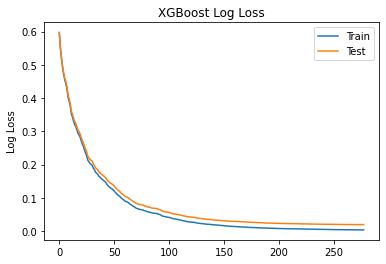

[0.96118252 0.95218509 0.96075407 0.96418166 0.93856041 0.94901457
 0.96280744 0.96220756 0.96177907 0.94224012]
Accuracy: 95.55% (0.89%)


In [8]:
#Initial Model Building
seed = 12345
test_size = 0.33
X = reduced_data_frame.iloc[:, [1,2,3,4,5,6,7,8]].to_numpy()
Y = reduced_data_frame.iloc[:, 9].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier(scale_pos_weight=50, learning_rate= .5, n_estimators = 300)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=4, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
#make predictions for training data. This will be compared to test results to check for overfitting. 
y_train_pred = model.predict(X_train)
train_predictions = [round(value) for value in y_train_pred]
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
train_accuracy = accuracy_score(y_train, train_predictions)
accuracy = accuracy_score(y_test, predictions)
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train, train_predictions).ravel()
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel() 
print("Training results:")
print("True Negative: " + str(train_tn))
print("False Positive: " + str(train_fp))
print("False Negative: " + str(train_fn))
print("True Positive: " + str(train_tp))
print("Test Results:")
print("True Negative: " + str(tn))
print("False Positive: " + str(fp))
print("False Negative: " + str(fn))
print("True Positive: " + str(tp))

#Looks like some overfitting may be ocurring. Let's check our learning curves. 
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# K-fold cross validation
kfold = KFold(n_splits=10)
results = cross_val_score(model, X, Y, cv=kfold)
print(results)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 23340  23341  23342 ... 116693 116694 116695] TEST: [    0     1     2 ... 23337 23338 23339]
Train Accuracy: 98.39%
Test Accuracy: 94.34%
Training results:
True Negative: 89926
False Positive: 1342
False Negative: 158
True Positive: 1930
Test Results:
True Negative: 21879
False Positive: 963
False Negative: 358
True Positive: 140


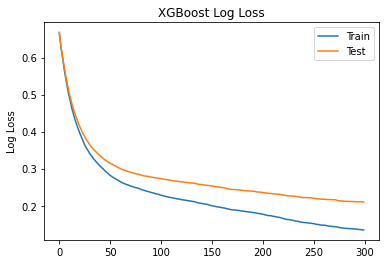

[0.95175664 0.93213368 0.94498715 0.95809769 0.9335904  0.93513282
 0.95072414 0.94532522 0.95089554 0.93332762]
Accuracy: 94.36% (0.89%)
TRAIN: [     0      1      2 ... 116693 116694 116695] TEST: [23340 23341 23342 ... 46676 46677 46678]
Train Accuracy: 96.89%
Test Accuracy: 94.14%
Training results:
True Negative: 89006
False Positive: 2309
False Negative: 598
True Positive: 1444
Test Results:
True Negative: 21807
False Positive: 988
False Negative: 380
True Positive: 164


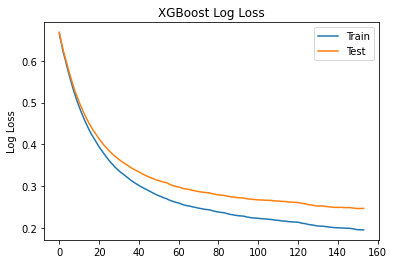

[0.95175664 0.93213368 0.94498715 0.95809769 0.9335904  0.93513282
 0.95072414 0.94532522 0.95089554 0.93332762]
Accuracy: 94.36% (0.89%)
TRAIN: [     0      1      2 ... 116693 116694 116695] TEST: [46679 46680 46681 ... 70015 70016 70017]
Train Accuracy: 98.08%
Test Accuracy: 93.29%
Training results:
True Negative: 89724
False Positive: 1593
False Negative: 199
True Positive: 1841
Test Results:
True Negative: 21650
False Positive: 1143
False Negative: 423
True Positive: 123


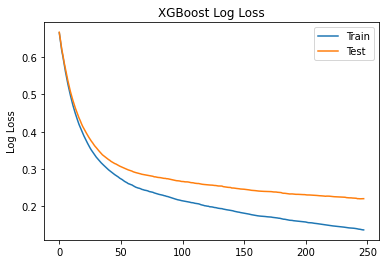

[0.95175664 0.93213368 0.94498715 0.95809769 0.9335904  0.93513282
 0.95072414 0.94532522 0.95089554 0.93332762]
Accuracy: 94.36% (0.89%)
TRAIN: [     0      1      2 ... 116693 116694 116695] TEST: [70018 70019 70020 ... 93354 93355 93356]
Train Accuracy: 98.00%
Test Accuracy: 94.87%
Training results:
True Negative: 89555
False Positive: 1665
False Negative: 205
True Positive: 1932
Test Results:
True Negative: 22053
False Positive: 837
False Negative: 361
True Positive: 88


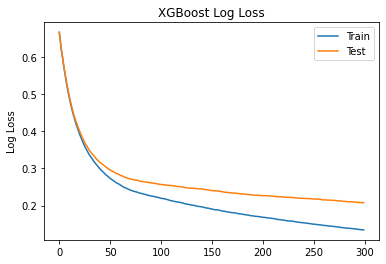

[0.95175664 0.93213368 0.94498715 0.95809769 0.9335904  0.93513282
 0.95072414 0.94532522 0.95089554 0.93332762]
Accuracy: 94.36% (0.89%)
TRAIN: [    0     1     2 ... 93354 93355 93356] TEST: [ 93357  93358  93359 ... 116693 116694 116695]
Train Accuracy: 98.20%
Test Accuracy: 95.84%
Training results:
True Negative: 89756
False Positive: 1564
False Negative: 115
True Positive: 1922
Test Results:
True Negative: 22297
False Positive: 493
False Negative: 477
True Positive: 72


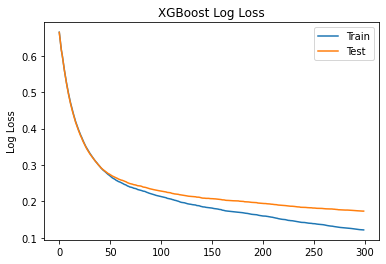

[0.95175664 0.93213368 0.94498715 0.95809769 0.9335904  0.93513282
 0.95072414 0.94532522 0.95089554 0.93332762]
Accuracy: 94.36% (0.89%)


In [9]:
# Custom cross validation
print(kfold)
kfold = KFold(n_splits=5)
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = XGBClassifier(scale_pos_weight=20, learning_rate= .05, n_estimators = 300, colsample_bytree=.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=4, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
    #make predictions for training data. This will be compared to test results to check for overfitting. 
    y_train_pred = model.predict(X_train)
    train_predictions = [round(value) for value in y_train_pred]
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    train_accuracy = accuracy_score(y_train, train_predictions)
    accuracy = accuracy_score(y_test, predictions)
    print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train, train_predictions).ravel()
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel() 
    print("Training results:")
    print("True Negative: " + str(train_tn))
    print("False Positive: " + str(train_fp))
    print("False Negative: " + str(train_fn))
    print("True Positive: " + str(train_tp))
    print("Test Results:")
    print("True Negative: " + str(tn))
    print("False Positive: " + str(fp))
    print("False Negative: " + str(fn))
    print("True Positive: " + str(tp))
    
    #Looks like some overfitting may be ocurring. Let's check our learning curves. 
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    # K-fold cross validation
    kfold = KFold(n_splits=10)
    results = cross_val_score(model, X, Y, cv=kfold)
    print(results)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


In [10]:
#Model Evaluation
# TODO: Graph ROC and gather AUC for final criteria


### Conclusions

<ul>
    <li> Cross Validation has showed that there is still potential overfitting. Validation error is much higher than the training error. </li>
    <li> The imbalance in positive/negative test cases is still not handled well. Increasing the weight has a detrimental impact on overall accuracy. </li>
    <li> Next steps would be to setup test cases to optimize the 3 hyperparameters set for XGBoost. </li>
</ul>